### This script is a port of EnergyID's code that calculates a linear regression on heating data

# Imports and setup

General imports

In [1]:
import pandas as pd

OpenGrid-specific imports

In [2]:
from opengrid.library import houseprint
from opengrid import config
from opengrid.library import linearregression

c = config.Config()

Plotting settings

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

# Load Data

We are going to use gas consumption data and weather data. Because we don't want to overload the weather API, we will only use 1 location (Ukkel).

First, let's define the start and end date of our experiment. Let's take 1 year worth of data, starting with last month.

In [4]:
# If we want to get consumption for 12 months, we will need 13 months of data
end = pd.Timestamp.today().replace(day=1).normalize()
start = (end.replace(year=end.year-1) - pd.Timedelta(days=1))

#start = start.tz_localize('Europe/Brussels')
#end = end.tz_localize('Europe/Brussels')
print(start, end)

2015-10-31 00:00:00 2016-11-01 00:00:00


## Gas Data

In [5]:
# Load the Houseprint, and sync all data
hp = houseprint.Houseprint()
#hp = houseprint.load_houseprint_from_file('cache_hp.hp')
hp.init_tmpo()
hp.sync_tmpos()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
24 Sites created
24 Devices created
75 sensors created
Houseprint parsing complete
Using tmpo database from /Users/Jan/.tmpo/tmpo.sqlite3


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/requests/packages/urllib3/connection.py:303: SubjectAltNameWarning: Certificate for api.flukso.net has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SubjectAltNameWarning
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/requests/packages/urllib3/connection.py:303: SubjectAltNameWarning: Certificate for api.flukso.net has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SubjectAltNameWarning
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/requests/packages/urllib3/connection.py:303: SubjectAltNameWarning: Certificate for api.fl

In [6]:
hp.save('cache_hp.hp')

Saved houseprint to /Users/Jan/opengrid/notebooks/Analysis/cache_hp.hp


In [7]:
def gas_data_generator():
    for gas_sensor in hp.get_sensors(sensortype='gas'):
        df = gas_sensor.get_data(head=start, tail=end, unit='kWh', diff=False)
        df = df.tz_convert('Europe/Brussels')
        df = df.resample('MS')
        df = df.diff().dropna()
        df = df[df>0]
        if df.empty:
            continue
        yield df

Let's have a peek

/Users/Jan/opengrid/opengrid/library/houseprint/sensor.py:267: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  newindex = data.resample(rule).index
-c:6: FutureWarning: 
.resample() is now a deferred operation
You called diff(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead


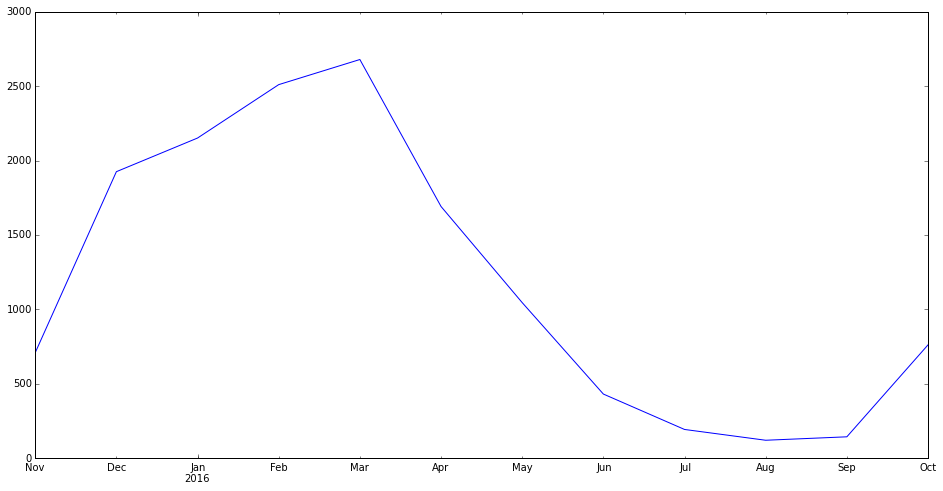

In [8]:
gas_data = gas_data_generator()
peek = next(gas_data)
#print(peek)
peek.plot()

## Weather Data

Run this block to download the weather data and save it to a pickle. This is a large request, and you can only do 2 or 3 of these per day before your credit with Forecast.io runs out!

TODO: Use the caching library for this.

To get the data run the cell below

In [31]:
from opengrid.library import forecastwrapper
weather = forecastwrapper.Weather(location='Ukkel, Belgium', start=start, end=end)
weather_data = weather.days().resample('MS').sum()

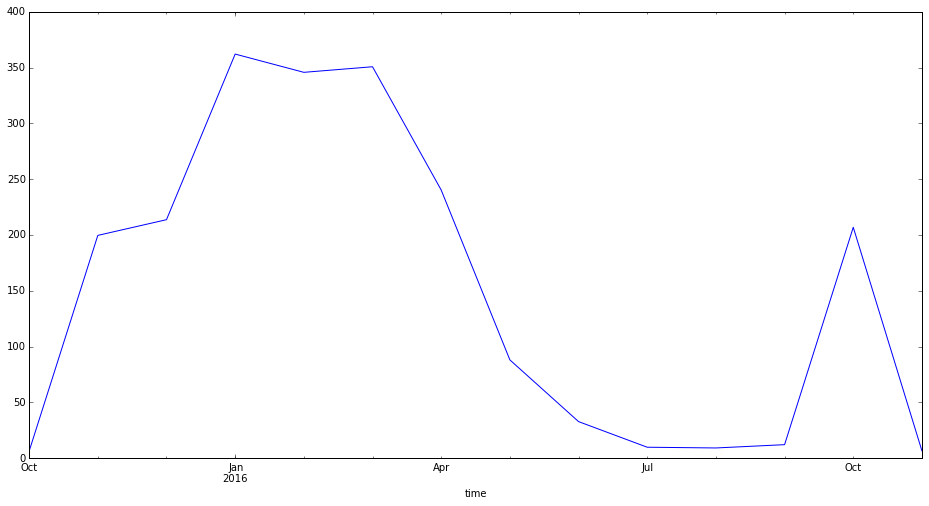

In [32]:
weather_data['heatingDegreeDays16.5'].plot()

# Put data together

We have defined an OpenGrid analysis as a class that takes a single DataFrame as input, so we'll create that dataframe.

I wrote a generator that uses our previously defined generator so you can generate while you generate.

In [33]:
def analysis_data_generator():
    gas_data = gas_data_generator()
    for gas_df in gas_data:
        df = pd.concat([gas_df, weather_data['heatingDegreeDays16.5']], axis=1).dropna()
        yield df

Let's have another peek

/Users/Jan/opengrid/opengrid/library/houseprint/sensor.py:267: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  newindex = data.resample(rule).index
-c:6: FutureWarning: 
.resample() is now a deferred operation
You called diff(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead


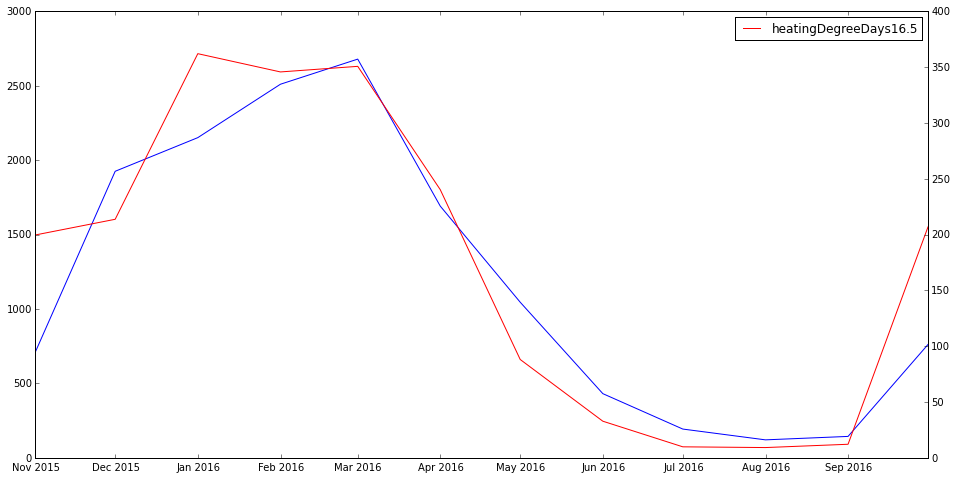

In [34]:
analysis_data = analysis_data_generator()
peek = next(analysis_data)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for axis, column, color in zip([ax1, ax2], peek.columns, ['b', 'r']):
    axis.plot_date(peek.index, peek[column], '-', color=color, label=column)
plt.legend()

# Run Regression Analysis

/Users/Jan/opengrid/opengrid/library/houseprint/sensor.py:267: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  newindex = data.resample(rule).index
-c:6: FutureWarning: 
.resample() is now a deferred operation
You called diff(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Data set is too small


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


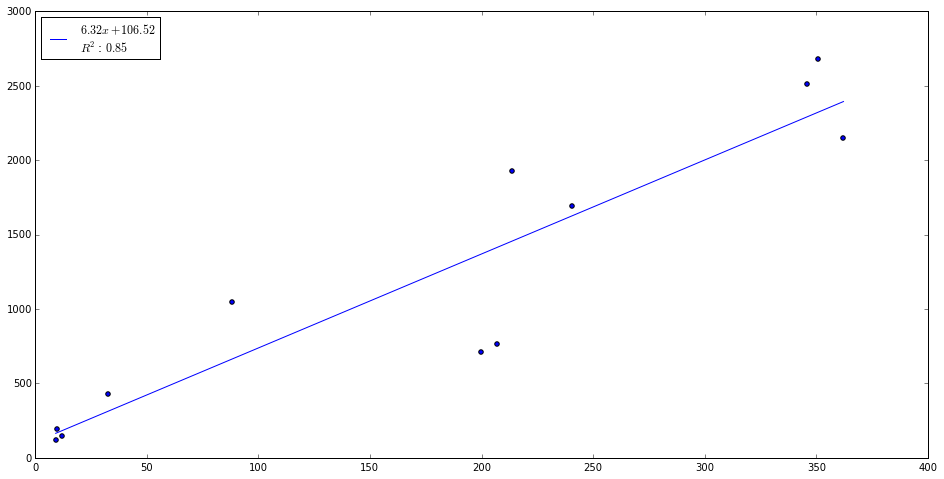

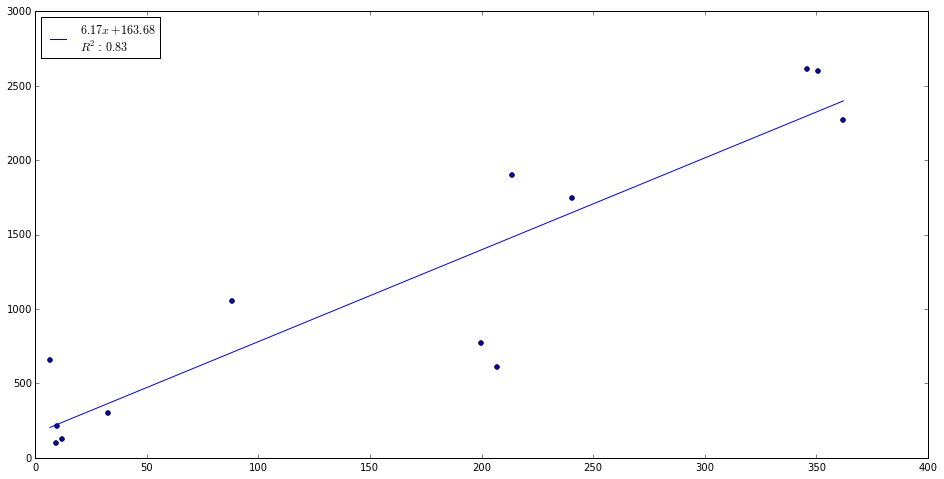

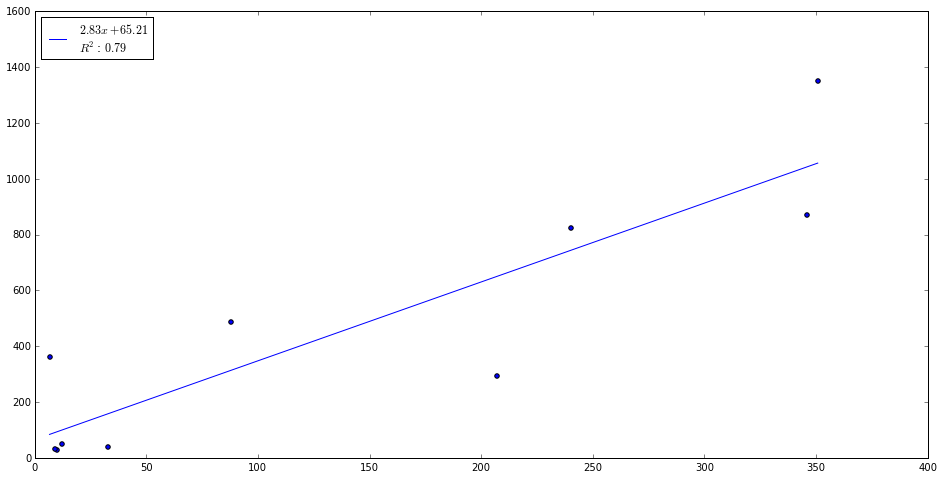

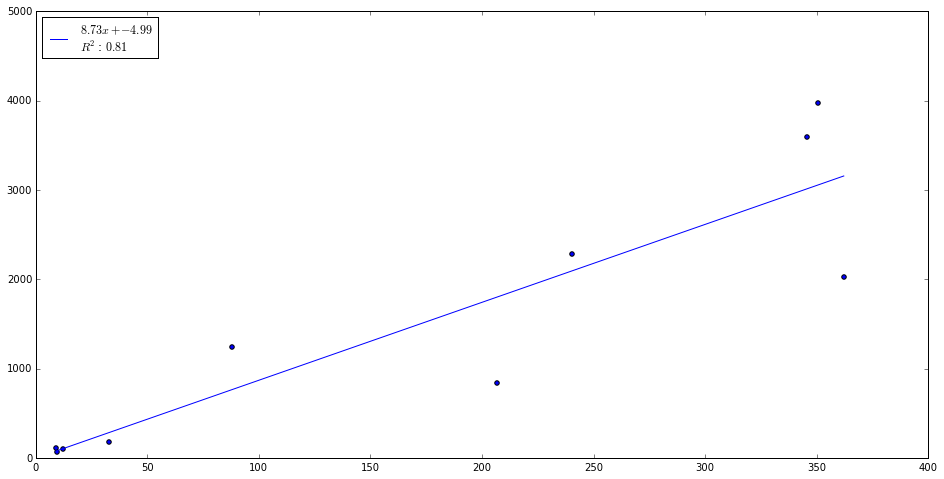

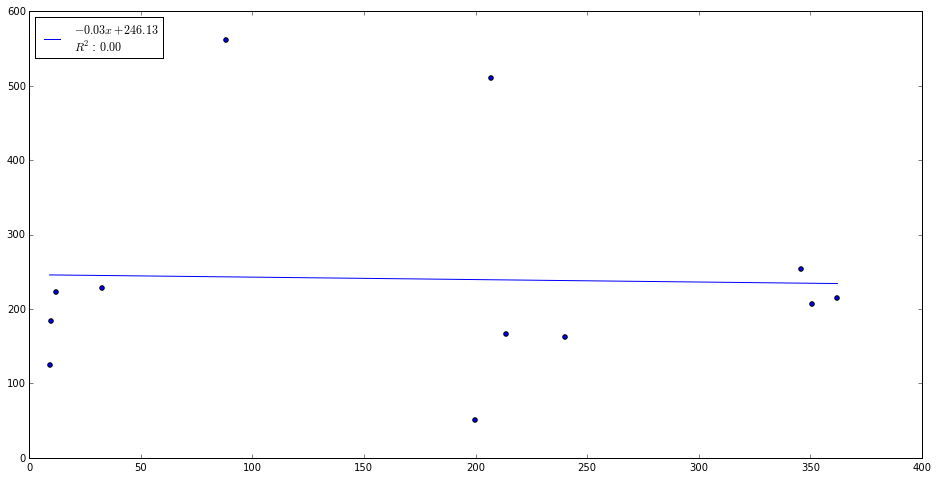

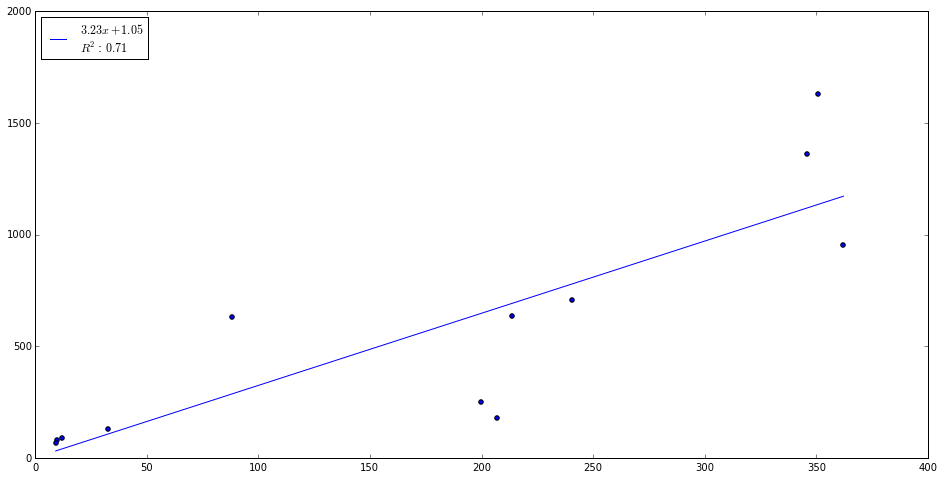

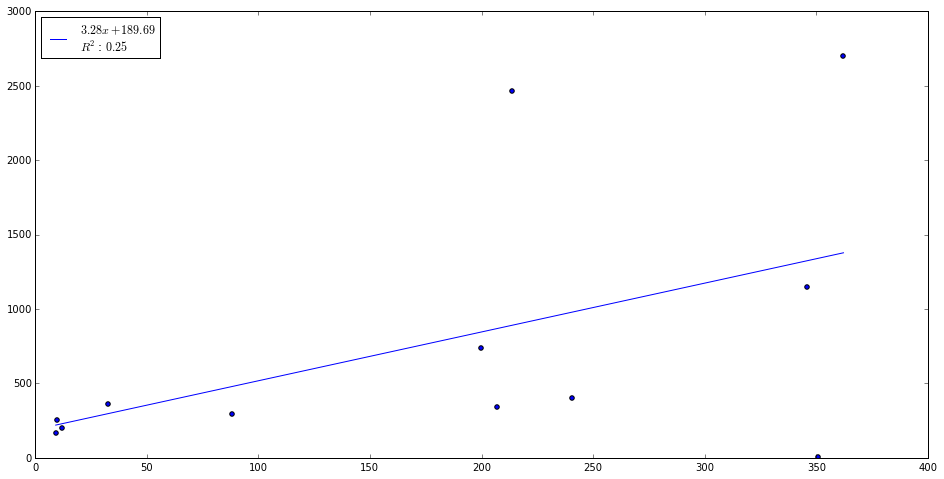

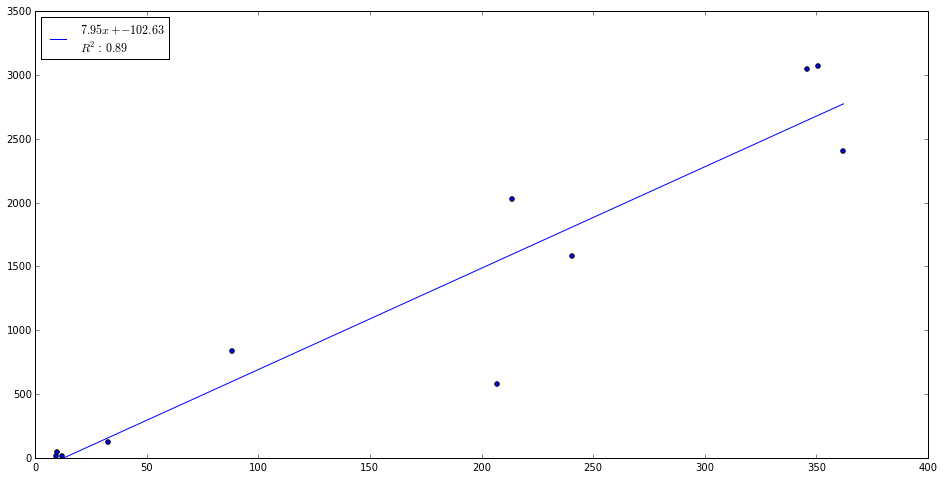

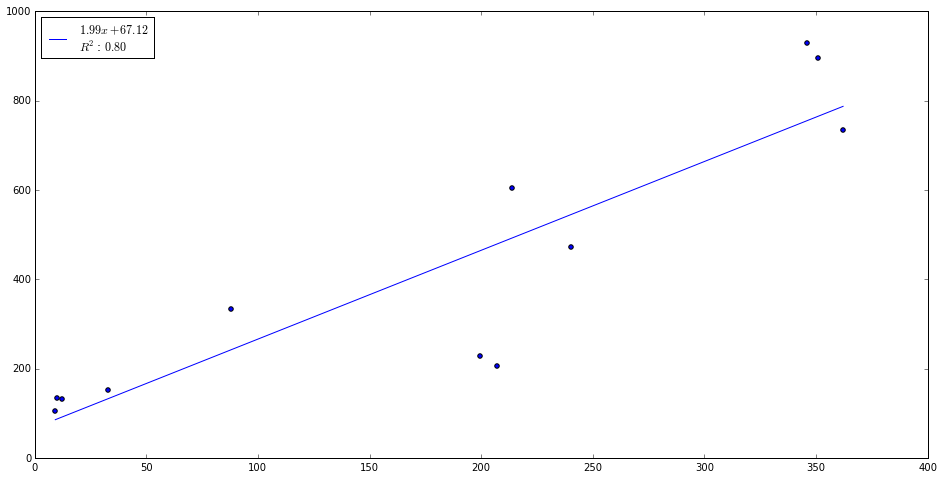

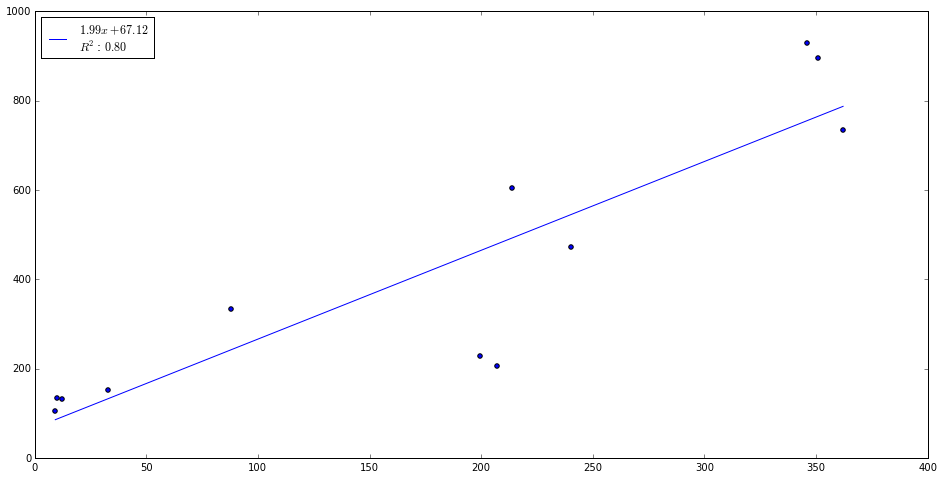

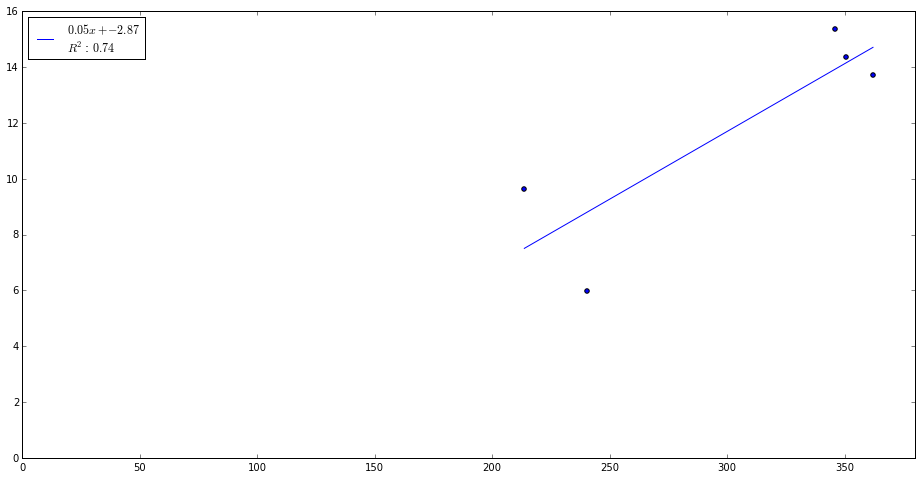

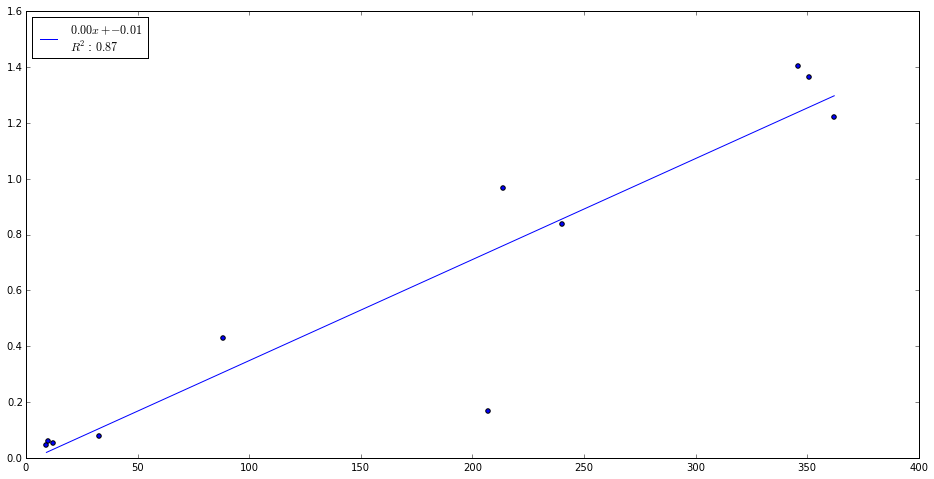

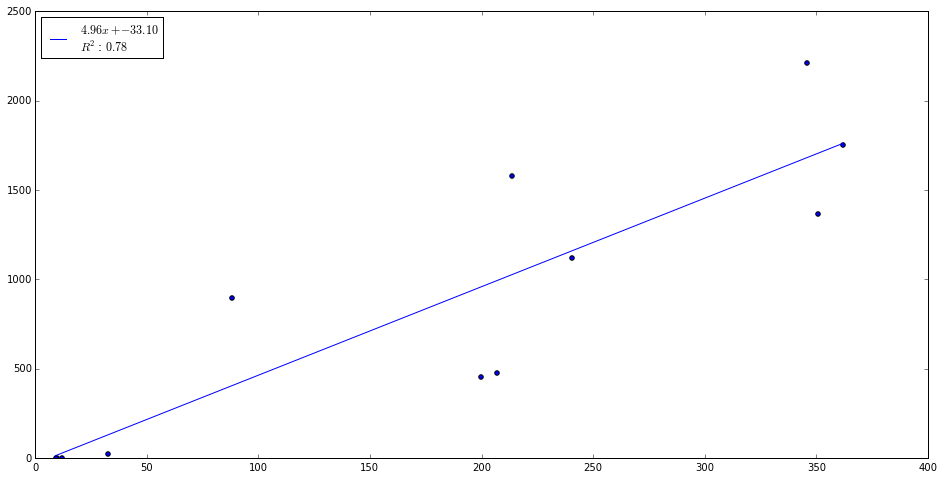

In [35]:
analysis_data = analysis_data_generator()
for data in analysis_data:
    
    # we need the names of the columns to pass to the analysis
    gas_column, degree_day_column = data.columns
    
    try:
        analysis = linearregression.LinearRegression(df=data,
                                                     independent_var=degree_day_column,
                                                     dependent_var=gas_column)
    except ValueError as e:
        print(e)

    fig = analysis.plot()
    fig.show()

/Users/Jan/opengrid/opengrid/library/houseprint/sensor.py:267: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  newindex = data.resample(rule).index
-c:6: FutureWarning: 
.resample() is now a deferred operation
You called diff(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead


Negative slope not possible for this type of regression Analysis
Data set is too small
Inferred frequency M from passed dates does not conform to passed frequency MS

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


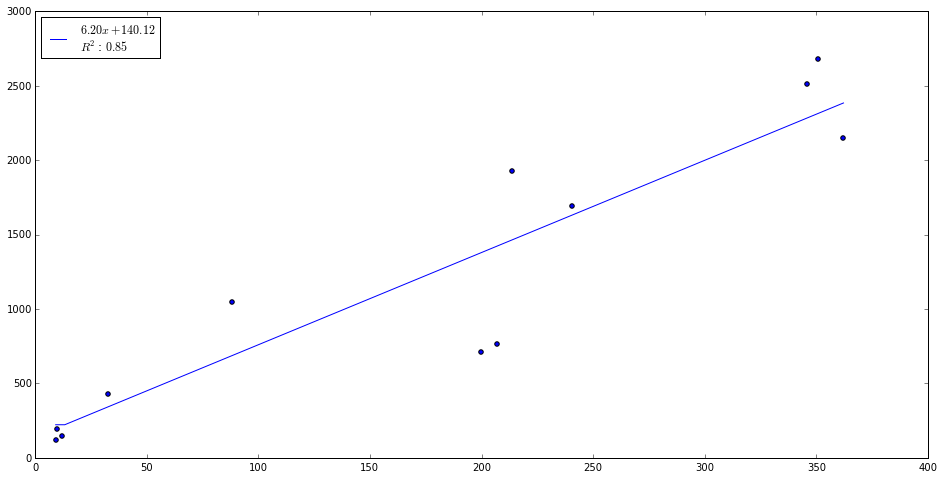

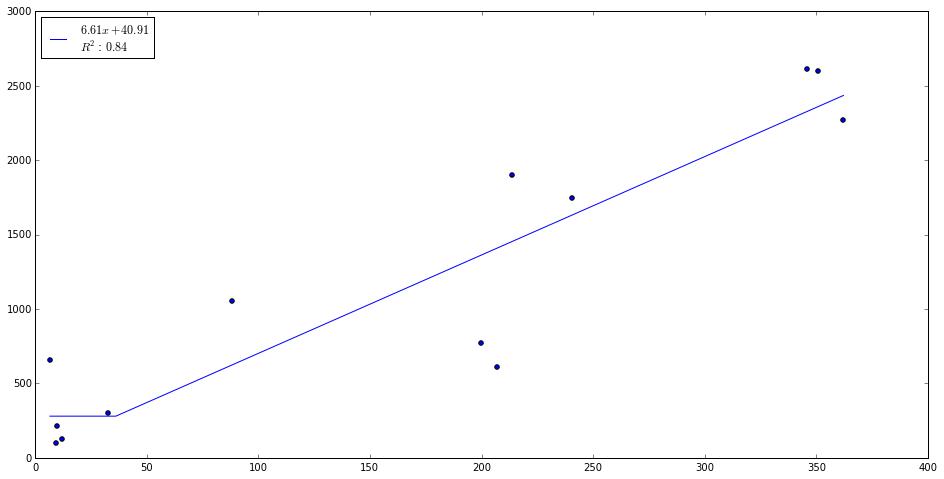

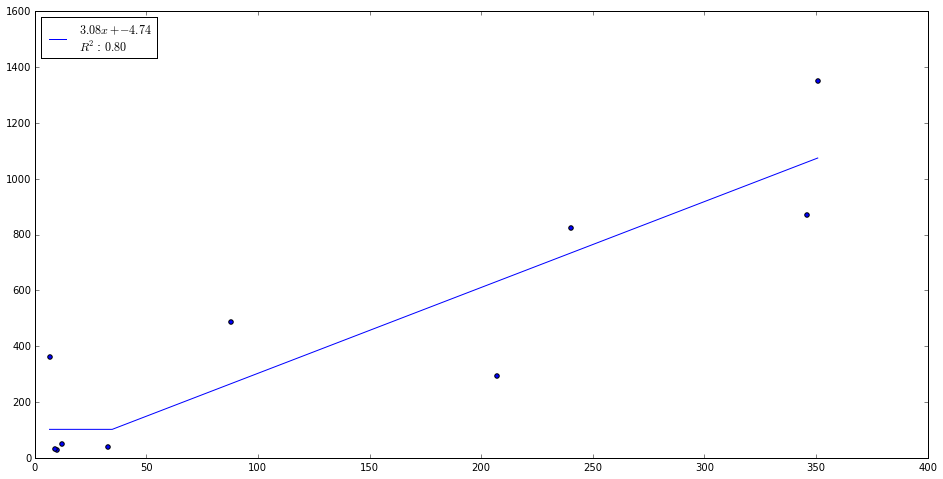

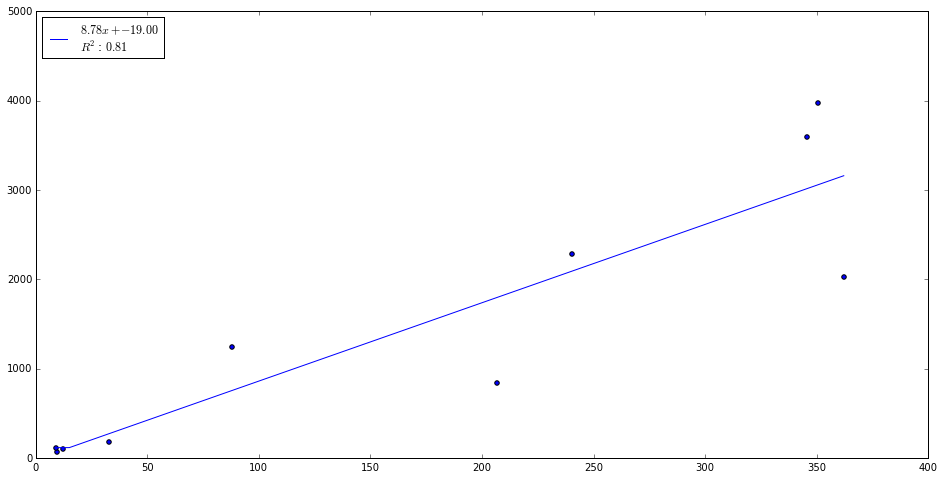

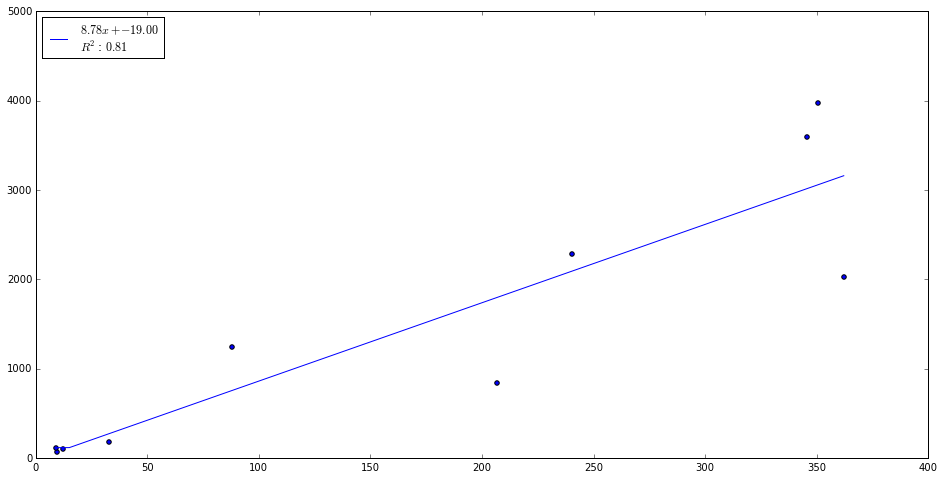

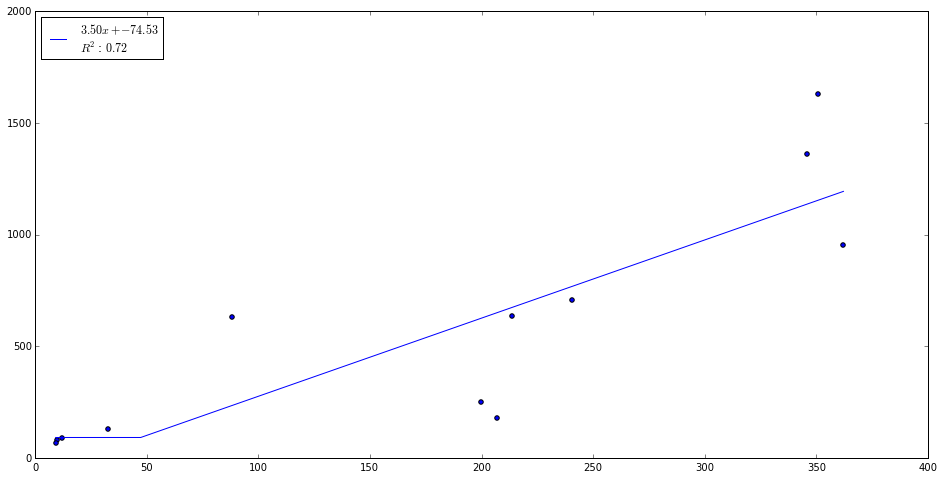

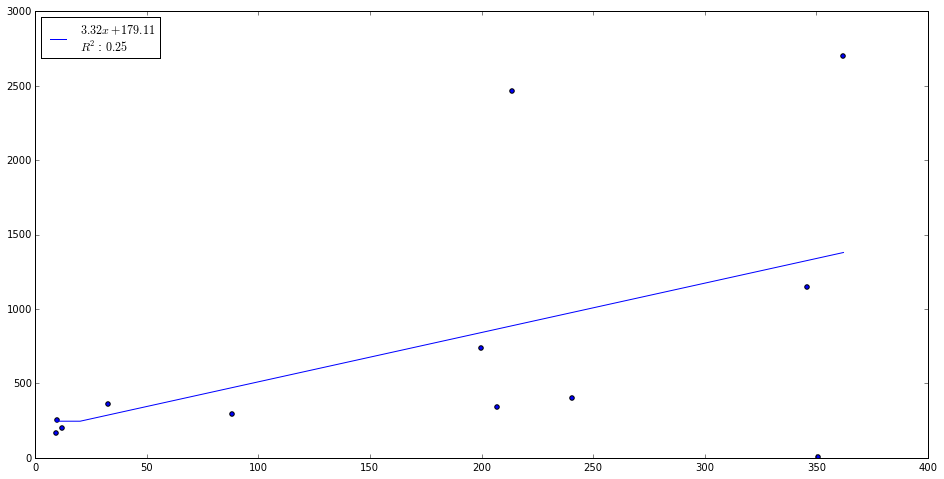

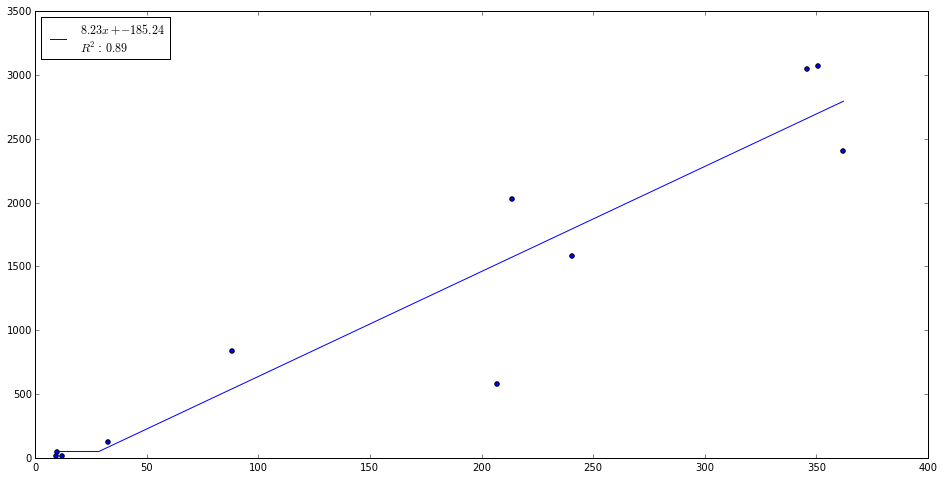

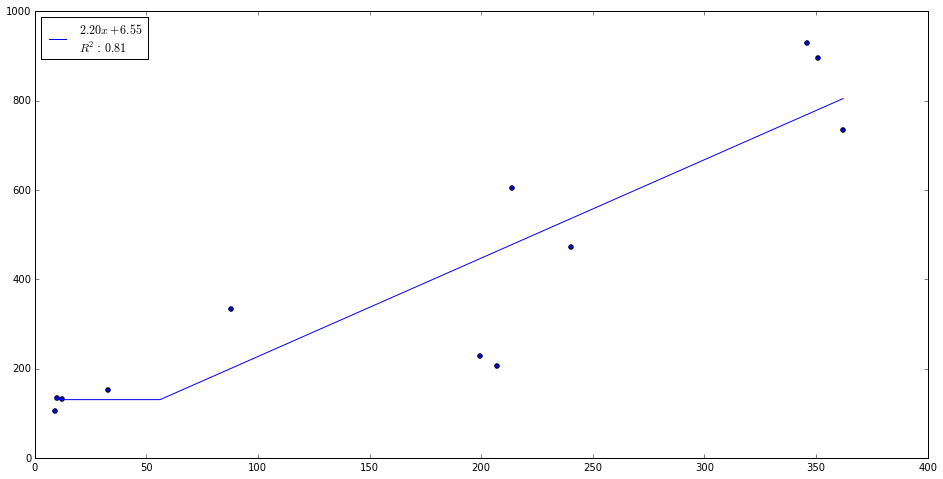

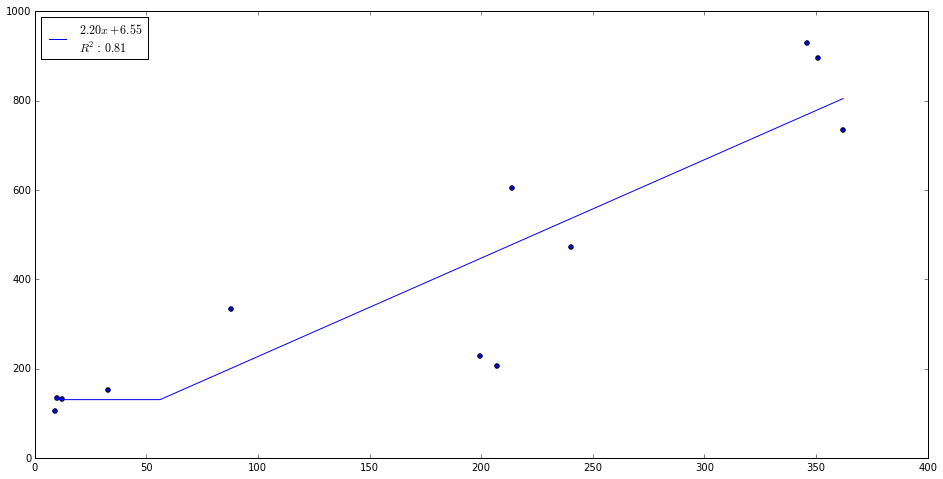

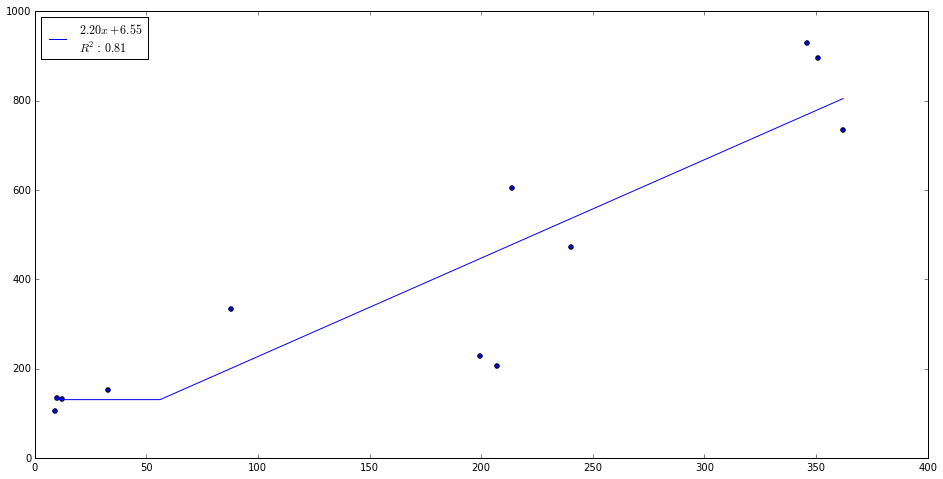

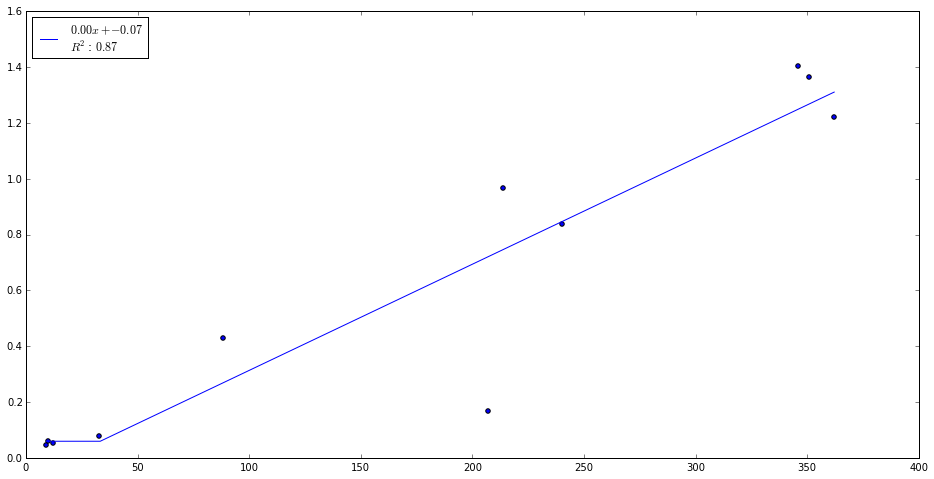

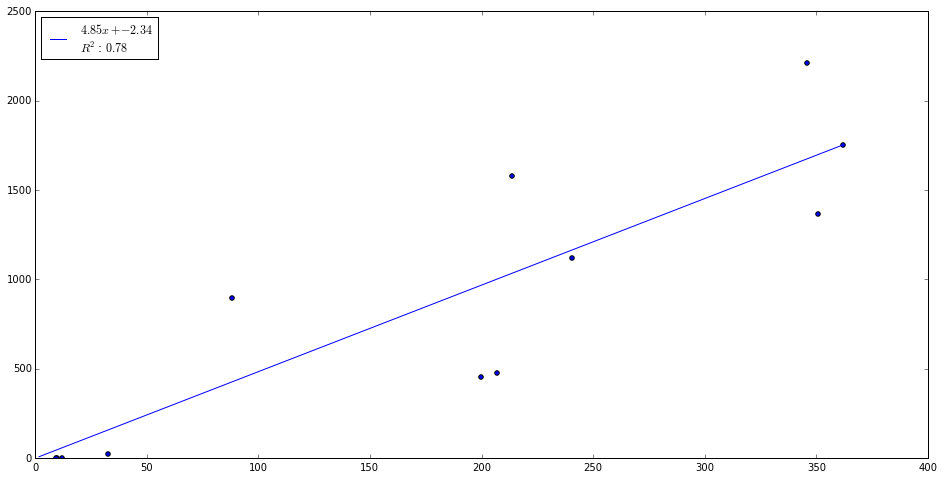

In [36]:
analysis_data = analysis_data_generator()
for data in analysis_data:
    
    # we need the names of the columns to pass to the analysis
    gas_column, degree_day_column = data.columns
    
    try:
        analysis = linearregression.LinearRegression3(df=data,
                                                      breakpoint=60,
                                                      percentage=0.5,
                                                      independent_var=degree_day_column,
                                                      dependent_var=gas_column)
    except ValueError as e:
        print(e)
    fig = analysis.plot()
    fig.show()